In [21]:
# Clustering Example 2 with K-Means ++ Implementation
# Dataset: Randomly generated blobs with variable variances and variable covariances (elliptical blobs)
#
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy as sp
import statsmodels as stats
from numpy import linalg as lin

from scipy.spatial.distance import mahalanobis

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import fetch_openml

import pdb
import time

In [22]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
# Vector-to-Vector Similarity Measures
#
def mahalanob_dist(a, b, cov_mat):
    # a is an m by n matrix, b is a 1 by n vector and cov_mat is a covariance matrix
    nrows = a.shape[0]
    mean_dev = (a - b).T
    inv_covmat_mult_mean_dev = lin.solve(cov_mat, mean_dev)
    maha_dist_sq = np.zeros((nrows,1))
    for mm in range(0,nrows):
      maha_dist_sq[mm] = np.dot(mean_dev[:,mm], inv_covmat_mult_mean_dev[:,mm])
    maha_dist = np.sqrt(maha_dist_sq)
    return maha_dist.flatten()


def mahalanobis_distance(a, b, cov_mat):
    # a is an m by n matrix, b is a 1 by n vector and cov_mat is a covariance matrix
    mean_dev = a - b
    inv_cov_mat = np.linalg.inv(cov_mat)
    maha_dist_sq = np.dot(np.dot(mean_dev, inv_cov_mat), mean_dev.T)
    maha_dist_sq = np.diag(maha_dist_sq)
    maha_dist = np.sqrt(maha_dist_sq)
    return maha_dist

def scipy_mahala(a, b, cov_mat):
    # a is an m by n matrix, b is a 1 by n vector and cov_mat is a covariance matrix
    # from scipy.spatial.distance import mahalanobis
    nrows = a.shape[0]
    inv_cov_mat = lin.inv(cov_mat)
    mm = 0
    maha_dist = np.zeros((nrows,))
    for vec in a:
      maha_dist[mm] = mahalanobis(vec, b, inv_cov_mat)
      mm += 1
    return maha_dist

def cos_sim(a,b):
    # a is an m by n matrix and b is a 1 by n vector
    ab_inner = np.inner(a,b)
    anorm = lin.vector_norm(a, axis = 1)
    bnorm = lin.vector_norm(b)
    sim_cos = ( ab_inner / (anorm * bnorm) )
    return sim_cos


def cos_dist(a,b):
    # a is an m by n matrix and b is a 1 by n vector
    cossim = cos_sim(a,b)
    dist_cos = 1 - cossim
    return dist_cos


def dot_prod_sim(a,b):
    sim_dot = np.inner(a,b)
    return sim_dot


def udp_sim(a,b):
    ab_inner = np.inner(a,b)
    anorm = lin.vector_norm(a, axis = 1)
    bnorm = lin.vector_norm(b)
    apb_norm = anorm + bnorm
    sim_udp = ab_inner / (apb_norm ** 2)
    return sim_udp


def city_dist(a,b):
    # a is an m by n matrix and b is a 1 by n vector
    d_city = np.sum(np.abs(a-b), axis = 1)
    return d_city


def euc_dist(a,b):
    # a is an m by n matrix and b is a 1 by n vector
    d_euc = np.sqrt( np.sum((a-b)**2, axis = 1) )
    return d_euc


def city_cos_dist(a, b, vphi):
    # a is an m by n matrix and b is a 1 by n vector
    # vphi = 3
    ab_inner = np.inner(a,b)
    anorm_sq = np.sum(a**2, axis = 1)
    bnorm_sq = np.sum(b**2)
    #
    anorm = np.sqrt(anorm_sq)
    bnorm = np.sqrt(bnorm_sq)
    #
    cos_theta = ab_inner / (anorm * bnorm)
    #
    d_cit = city_dist(a, b)
    #
    d_cit_cos = d_cit * np.abs(cos_theta - vphi)
    return d_cit_cos


def city_cos_sim(a, b, vphi):
    d_cit_cos = city_cos_dist(a, b, vphi)
    sim_cit_cos = 1 / d_cit_cos
    # sim_cit_cos = 1 / (1 + d_cit_cos)
    return sim_cit_cos


def euc_cos_dist(a, b, vphi):
    # a is an m by n matrix and b is a 1 by n vector
    # vphi = 7
    ab_inner = np.inner(a,b)
    anorm_sq = np.sum(a**2, axis = 1)
    bnorm_sq = np.sum(b**2)
    #
    anorm = np.sqrt(anorm_sq)
    bnorm = np.sqrt(bnorm_sq)
    #
    cos_theta = ab_inner / (anorm * bnorm)
    #
    # a_b_sq = anorm_sq - 2*ab_inner + bnorm_sq
    # d_euc = np.sqrt( a_b_sq )
    d_euc = euc_dist(a,b)
    #
    d_euc_cos = d_euc * np.abs(cos_theta - vphi)
    return d_euc_cos


def euc_cos_sim(a, b, vphi):
    d_euc_cos = euc_cos_dist(a, b, vphi)
    sim_euc_cos = 1 / d_euc_cos
    # sim_euc_cos = 1 / (1 + d_euc_cos)
    return sim_euc_cos


def mink_dist(a, b, p):
    # a is an m by n matrix and b is a 1 by n vector
    d_mink = np.power( np.sum(np.power(np.abs(a-b), p), axis = 1), 1/p )
    return d_mink


def mink_cos_dist(a, b, vphi, p):
    # a is an m by n matrix and b is a 1 by n vector
    ab_inner = np.inner(a,b)
    anorm_sq = np.sum(a**2, axis = 1)
    bnorm_sq = np.sum(b**2)
    #
    anorm = np.sqrt(anorm_sq)
    bnorm = np.sqrt(bnorm_sq)
    #
    cos_theta = ab_inner / (anorm * bnorm)
    #
    d_mink = mink_dist(a, b, p)
    #
    d_mink_cos = d_mink * np.abs(cos_theta - vphi)
    return d_mink_cos


In [23]:
# Code provided by google AI Assistant
import numpy as np

def get_dominant_eigenvector(matrix):
  """
  Calculates the dominant eigenvector of a square matrix.

  Args:
    matrix: A NumPy array representing the square matrix.

  Returns:
    A NumPy array representing the dominant eigenvector, or None if the input is invalid.
  """
  try:
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    dominant_eigenvalue_index = np.argmax(np.abs(eigenvalues))
    dominant_eigenvector = eigenvectors[:, dominant_eigenvalue_index]
    return dominant_eigenvector
  except np.linalg.LinAlgError:
      print("Input is not a square matrix or other error occurred")
      return None


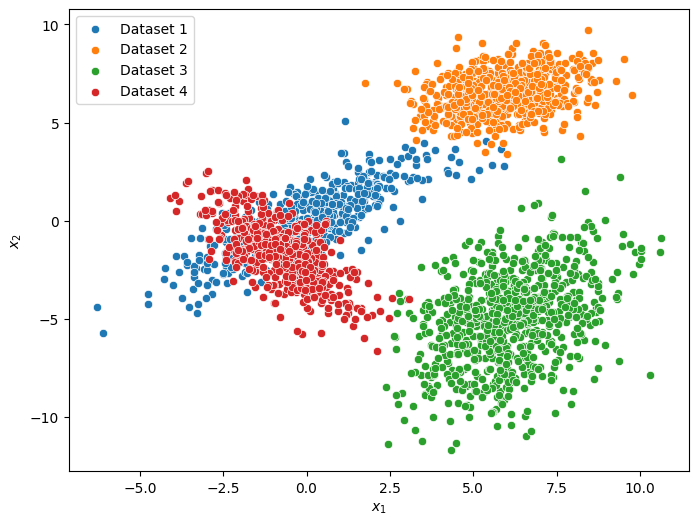

In [24]:
# Create datasets
# Adapted from: https://www.geeksforgeeks.org/ml-k-means-algorithm/
# Data creation

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

ndata1 = 500
ndata2 = 650
ndata3 = 750
ndata4 = 500
ndata5 = 500

# centers
mean_01 = np.array([0.0, 0.0])
mean_02 = np.array([6.0, 6.5])
mean_03 = np.array([6.1, -5.0])
mean_04 = np.array([-0.75, -1.8])
mean_05 = np.array([3.0, -7.0])

# Covariance matrices
cov_01 = np.array([[4, 2.83],
                   [2.83, 3]])

cov_02 = np.array([[1.5, 0.3],
                   [0.3, 1]])

cov_03 = np.array([[2.3, 1.5],
                   [1.5, 5.8]])

cov_04 = np.array([[1.2, -1.1],
                   [-1.1, 2.3]])

cov_05 = np.array([[1.2, 2.5],
                   [2.5, 2.3]])

# print('eigvals of cov_01:', lin.eig(cov_01))
# print('eigvals of cov_04:', lin.eig(cov_04))
# print('eigvals of cov_05:', lin.eig(cov_05))

dist_01 = np.random.multivariate_normal(mean_01, cov_01, ndata1)
y1 = np.zeros( (ndata1,1) )
dist_01 = np.append(dist_01, y1, axis=1)

dist_02 = np.random.multivariate_normal(mean_02, cov_02, ndata2)
y2 = np.ones( (ndata2,1) )
dist_02 = np.append(dist_02, y2, axis=1)

dist_03 = np.random.multivariate_normal(mean_03, cov_03, ndata3)
y3 = 2*np.ones( (ndata3,1) )
dist_03 = np.append(dist_03, y3, axis=1)

dist_04 = np.random.multivariate_normal(mean_04, cov_04, ndata4)
y4 = 3*np.ones( (ndata4,1) )
dist_04 = np.append(dist_04, y4, axis=1)

# dist_05 = np.random.multivariate_normal(mean_05, cov_05, ndata5)
# y5 = 4*np.ones( (ndata5,1) )
# dist_05 = np.append(dist_05, y5, axis=1)

data = np.vstack((dist_01, dist_02, dist_03, dist_04))
np.random.shuffle(data)

# ******************************************************************************
# Plot the datasets
# Create a figure and axes
plt.figure(figsize=(8, 6))
ax3 = plt.gca() # Get the current axes

# Plot each curve individually
sns.scatterplot(x = dist_01[:,0], y = dist_01[:,1], label = 'Dataset 1', ax = ax3)
sns.scatterplot(x = dist_02[:,0], y = dist_02[:,1], label = 'Dataset 2', ax = ax3)
sns.scatterplot(x = dist_03[:,0], y = dist_03[:,1], label = 'Dataset 3', ax = ax3)
sns.scatterplot(x = dist_04[:,0], y = dist_04[:,1], label = 'Dataset 4', ax = ax3)

# Add labels and title
ax3.set_xlabel(r'$x_1$')
ax3.set_ylabel(r'$x_2$')
# ax3.set_title('Multiple Curves on a Single Seaborn Line Plot')
# ax3.legend() # Display the legend for the labels
# Set specific x-axis tick locations
# ax3.set_xticks(np.arange(-7.5, 10, 0.5))

# Set specific x-axis tick labels
# ax.set_xticklabels(np.arange(0, 5.5, 0.5)


plt.show()

# ******************************************************************************

X = data[:, 0:-1]
y = data[:, -1]

df_data = pd.DataFrame(X, columns = ['x1', 'x2'])

df_data.head()

n_clusters = 4

In [25]:
# Find the length of the dataset
nrows, ncols = df_data.shape
# Plot the datapoints and centroids
# Ref: https://www.geeksforgeeks.org/ml-k-means-algorithm/
# Old centroids are in black color while new centroids are in red
def plot(data, centroids):
    plt.scatter(data[:, 0], data[:, 1], marker='.', color='gray', label='Data Points')
    if centroids.shape[0] > 1:
        plt.scatter(centroids[:-1, 0], centroids[:-1, 1], color='black', label='Selected Centroids')
    plt.scatter(centroids[-1, 0], centroids[-1, 1], color='red', label='Next Centroid')
    plt.title(f'Select {centroids.shape[0]}th Centroid')
    plt.legend()
    # plt.xlim(-4, 2)
    # plt.ylim(0, 4)
    plt.show()


In [26]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
def initialize_centroids(data, k, sim_meas, vphi_city = None, vphi_euc = None, vphi_mink = None, pval = None):
  nrows, ncols = data.shape
  #
  centroids = np.zeros( (k,ncols) )
  random_pick = np.random.randint(0,nrows)
  centroids[0,:] = data[random_pick,:]
  #
  centroids_0 = centroids[0:1,:]
  # plot(data, np.array(centroids_0))
  #
  dist = np.zeros((nrows,k))
  for i in range(k - 1):
      #
      for j, centro in enumerate(centroids[0:i+1, :]):
          if sim_meas == city_cos_dist:
            dist[:, j] = sim_meas(data, centro, vphi_city)
          elif sim_meas == euc_cos_dist:
            dist[:, j] = sim_meas(data, centro, vphi_euc)
          elif sim_meas == mink_cos_dist:
            dist[:, j] = sim_meas(data, centro, vphi_mink, pval)
          elif sim_meas == mahalanob_dist or sim_meas == scipy_mahala:
            # cov_mat = np.identity(ncols, dtype="int")
            # dist[:, j] = sim_meas(data, centro, cov_mat)
            dist[:,j] = euc_dist(data, centro)
          else:
            dist[:, j] = sim_meas(data, centro)
      #
      min_dist = np.min(dist[:,0:j+1], axis = 1)
      centroids[i+1, :] = data[np.argmax(min_dist)]

      centroids_i = centroids[0:i+2,:]

  return np.array(centroids)


In [27]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
def kmeans(df_clust, k, max_iter, sim_meas, vphi_city = None, vphi_euc = None, vphi_mink = None, pval = None):
  # Convert from dataframe obj to numpy object
  dat = df_clust.to_numpy()
  # dat = df_clust.values # this can also be used to covert to a numpy array
  #
  nrows, ncols = dat.shape
  if sim_meas == mahalanob_dist or sim_meas == scipy_mahala:
      cov_mats = np.zeros((k, ncols, ncols))
      for nn in range(k):
          cov_mat = np.identity(ncols, dtype="int")
          cov_mats[nn, :, :] = cov_mat
      #
  #
  # Find the initial centroids using KMeans++ algorithm
  init_centroids = initialize_centroids(dat, k, sim_meas, vphi_city, vphi_euc, vphi_mink, pval)
  centroids = init_centroids.copy()
  last_valid_centroids = centroids.copy()
  #
  # print('initial centoids:\n', centroids)
  #
  # Run the while loop of the KMeans to cluster the data
  tol = 1e-300
  chge = 10
  # max_iter = 100
  iter = 0
  while iter < (max_iter + 1) and tol < chge:
    iter = iter + 1
    #
    dist = np.zeros((nrows,k))
    dats = dat[:, :ncols]
    #
    # Pick each centroid and find the distances between all datapoints and each centroid
    for j in range(k):
      if sim_meas == city_cos_dist:
        dist[:, j] = sim_meas(dats, centroids[j,:], vphi_city)
      elif sim_meas == euc_cos_dist:
        dist[:, j] = sim_meas(dats, centroids[j,:], vphi_euc)
      elif sim_meas == mink_cos_dist:
        dist[:, j] = sim_meas(dats, centroids[j,:], vphi_mink, pval)
      elif sim_meas == mahalanob_dist or sim_meas == scipy_mahala:
        cov_mat = cov_mats[j, :, :]
        dist[:, j] = sim_meas(dats, centroids[j,:], cov_mat)
        # print('Maha dist:', dist[:, j])
      else:
        dist[:, j] = sim_meas(dats, centroids[j,:])
    pred_clust = np.argmin(dist, axis = 1)
    df_clust['pred_clust'] = np.argmin(dist, axis = 1)
    #
    # Group by 'cluster' and calculate the mean of other columns
    new_centroids_df = df_clust.groupby('pred_clust').mean().iloc[:, :ncols]
    #
    new_centroids = new_centroids_df.values
    n1, n2 = new_centroids.shape
    # pdb.set_trace()
    if n1 != k:
      centroids = last_valid_centroids.copy()
      df_clust = last_df_clust.copy()
      print('number of clusters is incorrect')
      print('Predicted No. of clusters:', n1)
      print('Actual No. of clusters:', k)
      print('last_valid_centroids:\n', centroids)
      print('KMeans terminating for the distance measure ... ', sim_meas)
      chge = 0
      break
    else:
      chge = np.sum( np.abs( new_centroids - centroids ) )
      centroids = new_centroids.copy()
      last_valid_centroids = centroids.copy()
      last_df_clust = df_clust.copy()
  #
    #
    if sim_meas == mahalanob_dist or sim_meas == scipy_mahala:
      grouped = df_clust.groupby('pred_clust')
      cov_mats = np.zeros((k, ncols, ncols))
      for id, group_df in grouped:
        grp_j = group_df.iloc[:, :ncols]
        cov_mat = grp_j.cov().values
        cov_mats[id, :, :] = cov_mat
      #
  return (df_clust, centroids, iter)


In [28]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
def get_accuracy(df_clust):
  #
  list_df_clust = []
  correct_predictions = 0

  for i in range(k):
    # Select rows where 'pred_clust' is equal to i
    clust_i = df_clust[df_clust['pred_clust'] == i]
    mode_value = clust_i['actual_clust'].mode()[0]
    mode_count = clust_i['actual_clust'].value_counts()[mode_value]
    correct_predictions += mode_count

    clust_i.loc[:, 'pred_clust'] = mode_value
    list_df_clust.append(clust_i)

  # Calculate the accuracy
  accuracy = correct_predictions / len(df_clust)

  # Concat the df_clust
  df_clustered = pd.concat(list_df_clust, ignore_index=True)

  return (accuracy, df_clustered)


In [29]:
# Set the random seeds for reproducibility and fair comparisons
rseeds = [121, 7643, 938, 28520, 2302, 17484, 8006, 893245, 377, 873469, 28283, 28941, 93989, 65387, 7365, 3957]
n_trials = 15 # len(rseeds)

# data = df_clust.to_numpy()
# data = df_clust.values # this is also a numpy array

# Create a dictionary of similarity measures
# key: similarity measures
# mahalanobis(a, b, inv_cov_mat)

# measures = {
#     1: cos_dist,
#     2: city_dist,
#     3: euc_dist,
#     4: city_cos_dist,
#     5: euc_cos_dist
# }

# measures = {
#     1: mahalanob_dist,
#     2: cos_dist,
#     3: city_dist,
#     4: euc_dist,
#     5: city_cos_dist,
#     6: euc_cos_dist
# }

# measures = {
#     1: mahalanobis_distance,
#     2: cos_dist,
#     3: city_dist,
#     4: euc_dist,
#     5: city_cos_dist,
#     6: euc_cos_dist
# }

measures = {
    1: scipy_mahala,
    2: cos_dist,
    3: city_dist,
    4: euc_dist,
    5: city_cos_dist,
    6: euc_cos_dist
}

n_meas = len(measures)


In [30]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
# Run the KMeans++ using the similarity measures named in the dictionary

# np.random.seed(rseeds[0])

# Create a 2-dimensional list to store the DataFrame objects after clustering
df_clustered_list = [ [None for _ in range(n_trials)] for _ in range(n_meas)]

# Create a 2-dimensional list to store the cntroids after clustering
centroids_list = [ [None for _ in range(n_trials)] for _ in range(n_meas)]

# Create 2-dimensional arrays to store the accuracies after clustering
accuracies = np.zeros( (n_meas, n_trials) )
adj_rand_scores = np.zeros( (n_meas, n_trials) )
n_iters = np.zeros( (n_meas, n_trials) )
elapsed_time = np.zeros( (n_meas,) )

# input the number of clusters
k = n_clusters

# Set the maximum number of iterations
max_iter = 100

# dummy pval and dummy vphi_mink
pval = 1
vphi_mink = 1

# Set the values of vphi
vphi_city = 3.75 #
vphi_euc = 2.6
# These are optimal for original data

# vphi_city = 2.25
# vphi_euc = 2.25
# These are optimal for sgd transformed data

# Loop over the sim measures
for key in measures:
  sim_meas = measures[key]
  print(f'Similarity Measure: {sim_meas}')
  #
  start_time = time.time()
  # Loop over the random seeds
  np.random.seed(1)
  for nt in np.arange(n_trials):
    #
    # Set the seed for reproducibility
    # np.random.seed(rseeds[nt])

    # Create acopy of the dataframe
    df_data_copy = df_data.copy()
    # Run the KMeans++ algorithm
    df_clustered, centroids, iters = kmeans(df_data_copy, k, max_iter, sim_meas, vphi_city, vphi_euc, vphi_mink, pval)
    #
    # Get the accuracy and the re-ordered clustered
    df_clustered['actual_clust'] = y
    # display(df_clustered.sample(15))
    # print(df_clustered['pred_clust'].min())
    # print(df_clustered['pred_clust'].unique())
    accur, ordered_clust = get_accuracy(df_clustered)

    accuracies[key-1][nt] = accur
    centroids_list[key-1][nt] = centroids
    df_clustered_list[key-1][nt] = ordered_clust
    adj_rand_scores[key-1][nt] = adjusted_rand_score(y, df_clustered['pred_clust'])
    n_iters[key-1][nt] = iters
  end_time = time.time()
  elapsed_time[key-1] = end_time - start_time
#
sum_n_iters = np.sum(n_iters, axis = 1)
print('No. of iters:\n', sum_n_iters)
print()
print('Elapsed Time:\n', elapsed_time)
print()

# display(ordered_clust)
# print()

# cols = ['Cos', 'City', 'Euc', 'JDM 1', 'JDM 2']
cols = ['Mahalanobis', 'Cos', 'City', 'Euc', 'JDM 1', 'JDM 2']

df_accuracies = pd.DataFrame(accuracies.T, index = rseeds[:n_trials], columns = cols)
# print('Accuracies:\n')
# display(df_accuracies)
print()

df_adj_rand_scores = pd.DataFrame(adj_rand_scores.T, index = rseeds[:n_trials], columns = cols)
# print('Adjusted Rand Score:\n')
# display(df_adj_rand_scores)
print()

df_accuracies_stat = df_accuracies.describe().round(4)
print('Stats of Accuracy:\n')
display(df_accuracies_stat)
print()

# Save file to desktop
df_accuracies_stat.to_csv('df_accuracies_stat.txt', sep='\t', index=True)
# df_accuracies_stat.to_csv('df_accuracies_stat_sgd.txt', sep='\t', index=True)
# sgd indicates standard Gaussian distribution

df_adj_rand_scores_stat = df_adj_rand_scores.describe().round(4)
print('Stats of Adjusted Rand Score:\n')
display(df_adj_rand_scores_stat)
print()

# Save file to desktop
df_adj_rand_scores_stat.to_csv('df_adj_rand_scores_stat.txt', sep='\t', index=True)
# df_adj_rand_scores_stat.to_csv('df_adj_rand_scores_stat_sgd.txt', sep='\t', index=True)
# sgd indicates standard Gaussian distribution

# pdb.set_trace()


Similarity Measure: <function scipy_mahala at 0x7d841cb9a840>
number of clusters is incorrect
Predicted No. of clusters: 3
Actual No. of clusters: 4
last_valid_centroids:
 [[ 4.53421725 -4.42026089]
 [ 7.06251957  6.42178986]
 [-1.74339249 -1.34559183]
 [ 1.65664493  2.22515489]]
KMeans terminating for the distance measure ...  <function scipy_mahala at 0x7d841cb9a840>
Similarity Measure: <function cos_dist at 0x7d841cb9a700>
Similarity Measure: <function city_dist at 0x7d841cb9aca0>
Similarity Measure: <function euc_dist at 0x7d841cb9ac00>
Similarity Measure: <function city_cos_dist at 0x7d841cb9b2e0>
Similarity Measure: <function euc_cos_dist at 0x7d841cb9b1a0>
No. of iters:
 [312. 486. 243. 185. 326. 204.]

Elapsed Time:
 [18.73938537  0.69695306  0.36022305  0.30127096  0.52057219  0.51163006]



Stats of Accuracy:



,Mahalanobis,Cos,City,Euc,JDM 1,JDM 2
count,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000
mean,0.7490,0.7025,0.8275,0.7980,0.8482,0.8480
std,0.0865,0.0001,0.0401,0.0298,0.0335,0.0401
min,0.5146,0.7025,0.7862,0.7867,0.7833,0.7837
25%,0.7479,0.7025,0.7862,0.7867,0.8633,0.8273
50%,0.7821,0.7025,0.8592,0.7867,0.8646,0.8708
75%,0.7846,0.7025,0.8598,0.7867,0.8646,0.8715
max,0.8600,0.7029,0.8704,0.8717,0.8646,0.8725



Stats of Adjusted Rand Score:



,Mahalanobis,Cos,City,Euc,JDM 1,JDM 2
count,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000
mean,0.5880,0.4927,0.7158,0.6589,0.7509,0.7423
std,0.1218,0.0010,0.0747,0.0553,0.0744,0.0932
min,0.3854,0.4892,0.6389,0.6371,0.6070,0.5931
25%,0.5275,0.4929,0.6389,0.6381,0.7843,0.6948
50%,0.6383,0.4929,0.7779,0.6381,0.7873,0.7966
75%,0.6419,0.4929,0.7784,0.6381,0.7873,0.7966
max,0.7979,0.4929,0.7916,0.7952,0.7873,0.7966


In [31]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
# Run the KMeans++ using the similarity measures named in the dictionary

# np.random.seed(rseeds[1])
np.random.seed(1)

# array of vphi values:
# city_vphis = np.arange(1.0, 2.0, 0.05).round(2)

city_vphis = np.arange(0, 5.05, 0.05).round(2)
# euc_vphis = np.arange(0., 5.05, 0.05).round(2)

# city_vphis = np.arange(0.4, 1.15, 0.05).round(2)
# euc_vphis = np.arange(0.4, 1.15, 0.05).round(2)

len_vphis = len(city_vphis)

# Create a 2-dimensional list to store the DataFrame objects after clustering
df_clustered_list = [ [None for _ in range(n_trials)] for _ in range(len_vphis)]

# Create a 2-dimensional list to store the centroids after clustering
centroids_list = [ [None for _ in range(n_trials)] for _ in range(len_vphis)]

# Create 2-dimensional arrays to store the accuracies after clustering
accuracies = np.zeros( (len_vphis, n_trials) )
adj_rand_scores = np.zeros( (len_vphis, n_trials) )

# input the number of clusters
k = n_clusters

# Set the maximum number of iterations
max_iter = 100

# dummy pval and dummy vphi_mink
pval = 1
vphi_mink = 1

# Set the values of vphi
# vphi_city = 2
vphi_euc = 7

mm = 0
sim_meas = city_cos_dist
# Loop over the sim measures
for vphi_city in city_vphis:
  # Loop over the random seeds
  np.random.seed(1)
  for nt in np.arange(n_trials):
    #
    # Set the seed for reproducibility
    # np.random.seed(rseeds[nt])

    # Create acopy of the dataframe
    df_data_copy = df_data.copy()
    # Run the KMeans++ algorithm
    df_clustered, centroids, _ = kmeans(df_data_copy, k, max_iter, sim_meas, vphi_city, vphi_euc, vphi_mink, pval)
    #
    # Get the accuracy and the re-ordered clustered
    df_clustered['actual_clust'] = y
    accur, ordered_clust = get_accuracy(df_clustered)

    accuracies[mm][nt] = accur
    centroids_list[mm][nt] = centroids
    df_clustered_list[mm][nt] = ordered_clust
    adj_rand_scores[mm][nt] = adjusted_rand_score(y, df_clustered['pred_clust'])
  #
  mm += 1

#
# display(ordered_clust)
# print()

cols = city_vphis

df_accuracies = pd.DataFrame(accuracies.T, index = rseeds[:n_trials], columns = cols)
# display(df_accuracies)
# print()

df_adj_rand_scores = pd.DataFrame(adj_rand_scores.T, index = rseeds[:n_trials], columns = cols)
# display(df_adj_rand_scores)
# print()

df_accuracies_stat_jdm1 = df_accuracies.describe().round(4)
print('Stats of Accuracy:\n')
display(df_accuracies_stat_jdm1)
print()

# Save file to desktop
df_accuracies_stat_jdm1.to_csv('df_accuracies_stat_jdm1_vphiv.txt', sep='\t', index=True)
# df_accuracies_stat.to_csv('df_accuracies_stat_jdm1_vphiv_sgd.txt', sep='\t', index=True)
# sgd indicates standard Gaussian distribution
# vphiv indicates variables values of vphi

df_adj_rand_scores_stat_jdm1 = df_adj_rand_scores.describe().round(4)
print('Stats of Adjusted Rand Score:\n')
display(df_adj_rand_scores_stat_jdm1)
print()

# Save file to desktop
df_adj_rand_scores_stat_jdm1.to_csv('df_adj_rand_scores_stat_jdm1_vphiv.txt', sep='\t', index=True)
# df_adj_rand_scores_stat_jdm1.to_csv('df_adj_rand_scores_stat_jdm1_vphiv_sgd.txt', sep='\t', index=True)
# sgd indicates standard Gaussian distribution
# vphiv indicates variables values of vphi


Stats of Accuracy:



,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,4.55,4.60,4.65,4.70,4.75,4.80,4.85,4.90,4.95,5.00
count,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,...,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000
mean,0.5527,0.5432,0.5669,0.5644,0.5760,0.5624,0.5512,0.5772,0.5303,0.5400,...,0.8369,0.8370,0.8370,0.8369,0.8369,0.8369,0.8369,0.8370,0.8370,0.8371
std,0.0445,0.0342,0.0358,0.0414,0.0397,0.0517,0.0558,0.0584,0.0430,0.0444,...,0.0380,0.0380,0.0380,0.0380,0.0380,0.0380,0.0380,0.0379,0.0379,0.0379
min,0.4792,0.4688,0.5233,0.5083,0.5021,0.4875,0.4304,0.4571,0.4258,0.4662,...,0.7850,0.7850,0.7850,0.7850,0.7850,0.7850,0.7850,0.7850,0.7850,0.7850
25%,0.5244,0.5290,0.5427,0.5337,0.5562,0.5223,0.5235,0.5381,0.5065,0.5079,...,0.7850,0.7850,0.7850,0.7850,0.7850,0.7850,0.7850,0.7854,0.7854,0.7854
50%,0.5579,0.5371,0.5654,0.5596,0.5800,0.5471,0.5662,0.5675,0.5337,0.5312,...,0.8629,0.8629,0.8629,0.8629,0.8629,0.8629,0.8629,0.8629,0.8629,0.8629
75%,0.5800,0.5662,0.5771,0.5838,0.5917,0.5948,0.5892,0.6294,0.5527,0.5675,...,0.8629,0.8629,0.8629,0.8629,0.8629,0.8629,0.8629,0.8629,0.8629,0.8629
max,0.6467,0.6154,0.6604,0.6754,0.6704,0.6646,0.6200,0.6554,0.6033,0.6188,...,0.8629,0.8633,0.8633,0.8629,0.8629,0.8629,0.8629,0.8629,0.8629,0.8633



Stats of Adjusted Rand Score:



,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,4.55,4.60,4.65,4.70,4.75,4.80,4.85,4.90,4.95,5.00
count,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,...,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000
mean,0.2450,0.2306,0.2596,0.2580,0.2801,0.2590,0.2634,0.2899,0.2461,0.2573,...,0.7281,0.7281,0.7281,0.7281,0.7281,0.7281,0.7281,0.7281,0.7281,0.7282
std,0.0384,0.0544,0.0406,0.0504,0.0577,0.0732,0.0500,0.0773,0.0470,0.0401,...,0.0817,0.0818,0.0818,0.0817,0.0817,0.0817,0.0817,0.0816,0.0816,0.0816
min,0.1737,0.1089,0.2000,0.1618,0.1748,0.1777,0.1933,0.1592,0.1173,0.1819,...,0.6164,0.6164,0.6164,0.6164,0.6164,0.6164,0.6164,0.6164,0.6164,0.6164
25%,0.2271,0.2047,0.2327,0.2299,0.2489,0.2009,0.2115,0.2348,0.2315,0.2386,...,0.6164,0.6164,0.6164,0.6164,0.6164,0.6164,0.6164,0.6169,0.6169,0.6169
50%,0.2525,0.2254,0.2510,0.2532,0.2661,0.2423,0.2813,0.2856,0.2472,0.2474,...,0.7840,0.7840,0.7840,0.7839,0.7839,0.7839,0.7839,0.7839,0.7839,0.7839
75%,0.2673,0.2550,0.2881,0.2853,0.3171,0.2953,0.3016,0.3515,0.2716,0.2659,...,0.7840,0.7840,0.7840,0.7839,0.7839,0.7839,0.7839,0.7839,0.7839,0.7839
max,0.3176,0.3534,0.3420,0.3698,0.4085,0.4097,0.3407,0.4144,0.3296,0.3337,...,0.7840,0.7843,0.7843,0.7839,0.7839,0.7839,0.7839,0.7839,0.7839,0.7842


In [32]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
# Run the KMeans++ using the similarity measures named in the dictionary

# np.random.seed(rseeds[1])
np.random.seed(1)

# array of vphi values:
euc_vphis = np.arange(0.0, 5.0, 0.05).round(2)

# euc_vphis = np.arange(0.4, 1.15, 0.05).round(2)

len_vphis = len(euc_vphis)

# Create a 2-dimensional list to store the DataFrame objects after clustering
df_clustered_list = [ [None for _ in range(n_trials)] for _ in range(len_vphis)]

# Create a 2-dimensional list to store the centroids after clustering
centroids_list = [ [None for _ in range(n_trials)] for _ in range(len_vphis)]

# Create 2-dimensional arrays to store the accuracies after clustering
accuracies = np.zeros( (len_vphis, n_trials) )
adj_rand_scores = np.zeros( (len_vphis, n_trials) )

# input the number of clusters
k = n_clusters

# Set the maximum number of iterations
max_iter = 100

# dummy pval and dummy vphi_mink
pval = 1
vphi_mink = 1

# Set the values of vphi
vphi_city = 2
# vphi_euc = 7

mm = 0
sim_meas = euc_cos_dist
# Loop over the sim measures
for vphi_euc in euc_vphis:
  # Loop over the random seeds
  np.random.seed(1)
  for nt in np.arange(n_trials):
    #
    # Set the seed for reproducibility
    # np.random.seed(rseeds[nt])

    # Create acopy of the dataframe
    df_data_copy = df_data.copy()
    # Run the KMeans++ algorithm
    df_clustered, centroids, _ = kmeans(df_data_copy, k, max_iter, sim_meas, vphi_city, vphi_euc, vphi_mink, pval)
    #
    # Get the accuracy and the re-ordered clustered
    df_clustered['actual_clust'] = y
    accur, ordered_clust = get_accuracy(df_clustered)

    accuracies[mm][nt] = accur
    centroids_list[mm][nt] = centroids
    df_clustered_list[mm][nt] = ordered_clust
    adj_rand_scores[mm][nt] = adjusted_rand_score(y, df_clustered['pred_clust'])
  #
  mm += 1

#
# display(ordered_clust)
# print()

cols = euc_vphis

df_accuracies = pd.DataFrame(accuracies.T, index = rseeds[:n_trials], columns = cols)
# display(df_accuracies)
# print()

df_adj_rand_scores = pd.DataFrame(adj_rand_scores.T, index = rseeds[:n_trials], columns = cols)
# display(df_adj_rand_scores)
# print()

df_accuracies_stat_jdm2 = df_accuracies.describe().round(4)
print('Stats of Accuracy:\n')
display(df_accuracies_stat_jdm2)
print()

# Save file to desktop
df_accuracies_stat_jdm2.to_csv('df_accuracies_stat_jdm2_vphiv.txt', sep='\t', index=True)
# df_accuracies_stat_jdm2.to_csv('df_accuracies_stat_jdm2_vphiv_sgd.txt', sep='\t', index=True)
# sgd indicates standard Gaussian distribution
# vphiv indicates variables values of vphi

df_adj_rand_scores_stat_jdm2 = df_adj_rand_scores.describe().round(4)
print('Stats of Adjusted Rand Score:\n')
display(df_adj_rand_scores_stat_jdm2)
print()

# Save file to desktop
df_adj_rand_scores_stat_jdm2.to_csv('df_adj_rand_scores_stat_jdm2_vphiv.txt', sep='\t', index=True)
# df_adj_rand_scores_stat_jdm2.to_csv('df_adj_rand_scores_stat_jdm2_vphiv_sgd.txt', sep='\t', index=True)
# sgd indicates standard Gaussian distribution
# vphiv indicates variables values of vphi

# df_accuracies.plot
# print()

# display(df_accuracies.mean(axis = 1))
# print()
# display(df_adj_rand_scores.mean(axis = 1))


Stats of Accuracy:



,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,4.50,4.55,4.60,4.65,4.70,4.75,4.80,4.85,4.90,4.95
count,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,...,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000
mean,0.5675,0.5638,0.5420,0.5697,0.5679,0.5594,0.5430,0.5707,0.5765,0.6051,...,0.8142,0.8202,0.8141,0.8143,0.8143,0.8144,0.8144,0.8143,0.8143,0.8144
std,0.0332,0.0463,0.0533,0.0500,0.0571,0.0613,0.0525,0.0455,0.0436,0.0406,...,0.0434,0.0452,0.0432,0.0431,0.0431,0.0430,0.0430,0.0429,0.0429,0.0428
min,0.5179,0.4762,0.4488,0.4571,0.4762,0.4562,0.4592,0.4667,0.4550,0.5092,...,0.7842,0.7842,0.7842,0.7846,0.7846,0.7846,0.7846,0.7846,0.7846,0.7850
25%,0.5481,0.5448,0.5167,0.5492,0.5231,0.5167,0.5081,0.5412,0.5629,0.5802,...,0.7842,0.7842,0.7844,0.7846,0.7846,0.7846,0.7848,0.7848,0.7848,0.7850
50%,0.5638,0.5538,0.5396,0.5771,0.5888,0.5554,0.5288,0.5888,0.5746,0.6050,...,0.7846,0.7846,0.7846,0.7846,0.7846,0.7850,0.7850,0.7850,0.7850,0.7850
75%,0.5810,0.5902,0.5644,0.5990,0.6088,0.6085,0.5873,0.6042,0.6004,0.6298,...,0.8733,0.8733,0.8725,0.8725,0.8725,0.8725,0.8725,0.8725,0.8725,0.8725
max,0.6333,0.6388,0.6738,0.6388,0.6367,0.6596,0.6388,0.6192,0.6354,0.6696,...,0.8742,0.8742,0.8742,0.8742,0.8742,0.8742,0.8742,0.8742,0.8742,0.8742



Stats of Adjusted Rand Score:



,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,4.50,4.55,4.60,4.65,4.70,4.75,4.80,4.85,4.90,4.95
count,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,...,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000
mean,0.2598,0.2486,0.2349,0.2636,0.2714,0.2648,0.2550,0.2799,0.2969,0.3293,...,0.6828,0.6960,0.6838,0.6839,0.6839,0.6840,0.6840,0.6840,0.6839,0.6843
std,0.0343,0.0616,0.0713,0.0684,0.0545,0.0688,0.0682,0.0607,0.0448,0.0381,...,0.0899,0.0916,0.0891,0.0890,0.0890,0.0889,0.0889,0.0888,0.0887,0.0887
min,0.2091,0.1471,0.1036,0.1112,0.1728,0.1801,0.1520,0.1745,0.2185,0.2834,...,0.6126,0.6144,0.6144,0.6149,0.6149,0.6149,0.6149,0.6149,0.6149,0.6153
25%,0.2338,0.1957,0.1978,0.2258,0.2329,0.2005,0.1985,0.2340,0.2726,0.3027,...,0.6128,0.6144,0.6146,0.6149,0.6149,0.6149,0.6151,0.6151,0.6151,0.6153
50%,0.2517,0.2530,0.2328,0.2704,0.2853,0.2630,0.2636,0.3153,0.2893,0.3242,...,0.6134,0.6149,0.6149,0.6149,0.6149,0.6153,0.6153,0.6153,0.6153,0.6153
75%,0.2831,0.2797,0.2637,0.3004,0.3147,0.3077,0.3043,0.3241,0.3155,0.3662,...,0.7983,0.7983,0.7979,0.7979,0.7979,0.7979,0.7979,0.7979,0.7977,0.7979
max,0.3304,0.3391,0.4344,0.4014,0.3383,0.3914,0.3728,0.3436,0.3910,0.3940,...,0.7991,0.7991,0.7991,0.7991,0.7991,0.7991,0.7991,0.7991,0.7991,0.7991


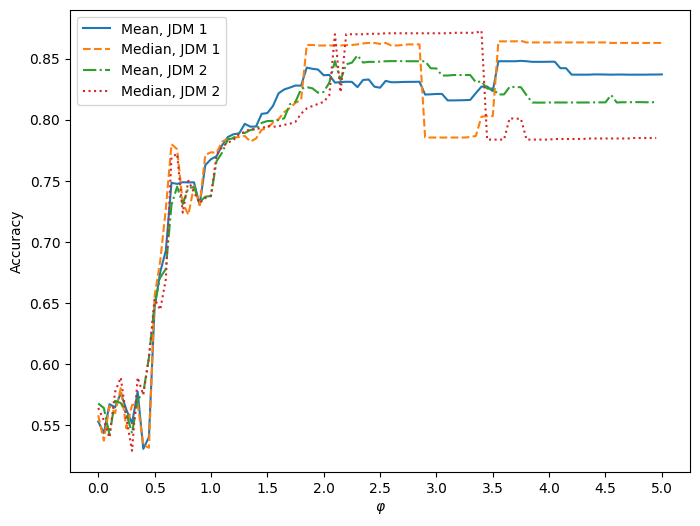

In [33]:
# Create the line plot of Accuracy
vphis_jdm1 = df_accuracies_stat_jdm1.columns
means_jdm1 = df_accuracies_stat_jdm1.loc['mean']
medians_jdm1 = df_accuracies_stat_jdm1.loc['50%']

vphis_jdm2 = df_accuracies_stat_jdm2.columns
means_jdm2 = df_accuracies_stat_jdm2.loc['mean']
medians_jdm2 = df_accuracies_stat_jdm2.loc['50%']

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax3 = plt.gca() # Get the current axes

# Plot each curve individually
sns.lineplot(x = vphis_jdm1, y = means_jdm1, label = 'Mean, JDM 1', ax = ax3)
sns.lineplot(x = vphis_jdm1, y = medians_jdm1, label = 'Median, JDM 1', linestyle="--", ax = ax3)
sns.lineplot(x = vphis_jdm2, y = means_jdm2, label = 'Mean, JDM 2', linestyle="-.", ax = ax3)
sns.lineplot(x = vphis_jdm2, y = medians_jdm2, label = 'Median, JDM 2', linestyle=":", ax = ax3)

# Add labels and title
ax3.set_xlabel(r'$\varphi$')
ax3.set_ylabel('Accuracy')
# ax3.set_title('Multiple Curves on a Single Seaborn Line Plot')
ax3.legend() # Display the legend for the labels
# Set specific x-axis tick locations
ax3.set_xticks(np.arange(0, 5.5, 0.5))

plt.show()

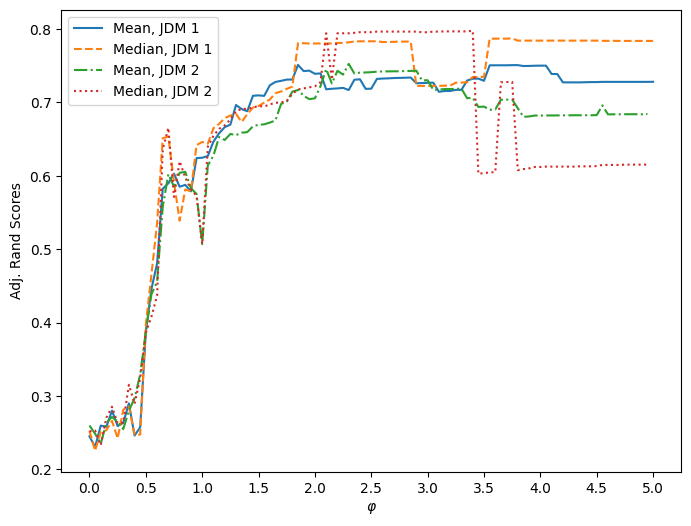

In [34]:
# Create the line plot of Adjusted Rand Scores
vphis_jdm1 = df_adj_rand_scores_stat_jdm1.columns
means_jdm1 = df_adj_rand_scores_stat_jdm1.loc['mean']
medians_jdm1 = df_adj_rand_scores_stat_jdm1.loc['50%']

vphis_jdm2 = df_adj_rand_scores_stat_jdm2.columns
means_jdm2 = df_adj_rand_scores_stat_jdm2.loc['mean']
medians_jdm2 = df_adj_rand_scores_stat_jdm2.loc['50%']

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax4 = plt.gca() # Get the current axes

# Plot each curve individually
sns.lineplot(x = vphis_jdm1, y = means_jdm1, label = 'Mean, JDM 1', ax = ax4)
sns.lineplot(x = vphis_jdm1, y = medians_jdm1, label = 'Median, JDM 1', linestyle="--", ax = ax4)
sns.lineplot(x = vphis_jdm2, y = means_jdm2, label = 'Mean, JDM 2', linestyle="-.", ax = ax4)
sns.lineplot(x = vphis_jdm2, y = medians_jdm2, label = 'Median, JDM 2', linestyle=":", ax = ax4)

# Add labels and title
ax4.set_xlabel(r'$\varphi$')
ax4.set_ylabel('Adj. Rand Scores')
# ax4.set_title('Multiple Curves on a Single Seaborn Line Plot')
ax4.legend() # Display the legend for the labels
# Set specific x-axis tick locations
ax4.set_xticks(np.arange(0, 5.5, 0.5))

plt.show()


In [35]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
# Run the KMeans++ using the similarity measures named in the dictionary

# np.random.seed(rseeds[1])
np.random.seed(1)

# array of p values:
pvals = np.arange(0.05, 5.05, 0.05).round(2)
len_ps = len(pvals)

# array of vphi values:
jdm_vphis = np.array([0.0, 0.5, 1.0, 2.5, 5.0])
len_vphis = len(jdm_vphis)

# Create a 2-dimensional list to store the DataFrame objects after clustering
df_clustered_list = [ [None for _ in range(n_trials)] for _ in range(len_ps)]

# Create a 2-dimensional list to store the centroids after clustering
centroids_list = [ [None for _ in range(n_trials)] for _ in range(len_ps)]

# Create 2-dimensional arrays to store the accuracies after clustering
accuracies = np.zeros( (len_ps, n_trials) )
adj_rand_scores = np.zeros( (len_ps, n_trials) )

mean_accuracies = np.zeros( (len_vphis, len_ps) )
mean_adj_rand_scores = np.zeros( (len_vphis, len_ps) )

median_accuracies = np.zeros( (len_vphis, len_ps) )
median_adj_rand_scores = np.zeros( (len_vphis, len_ps) )

# input the number of clusters
k = n_clusters

# Set the maximum number of iterations
max_iter = 100

# Set dummy values for vphi_city and vphi_euc
vphi_city = 1
vphi_euc = 1

nn = 0
sim_meas = mink_cos_dist
# Loop over the sim measures
for vphi_mink in jdm_vphis:
  mm = 0
  for pval in pvals:
    # Loop over the random seeds
    np.random.seed(1)
    for nt in np.arange(n_trials):
      #
      # Set the seed for reproducibility
      # np.random.seed(rseeds[nt])

      # Create acopy of the dataframe
      df_data_copy = df_data.copy()
      # Run the KMeans++ algorithm
      df_clustered, centroids, _ = kmeans(df_data_copy, k, max_iter, sim_meas, vphi_city, vphi_euc, vphi_mink, pval)
      #
      # Get the accuracy and the re-ordered clustered
      df_clustered['actual_clust'] = y
      accur, ordered_clust = get_accuracy(df_clustered)

      accuracies[mm][nt] = accur
      centroids_list[mm][nt] = centroids
      df_clustered_list[mm][nt] = ordered_clust
      adj_rand_scores[mm][nt] = adjusted_rand_score(y, df_clustered['pred_clust'])
    mm += 1
  #
  mean_accuracies[nn] = accuracies.mean(axis = 1)
  mean_adj_rand_scores[nn] = adj_rand_scores.mean(axis = 1)

  median_accuracies[nn] = np.median(accuracies, axis = 1)
  median_adj_rand_scores[nn] = np.median(adj_rand_scores, axis = 1)
  nn += 1


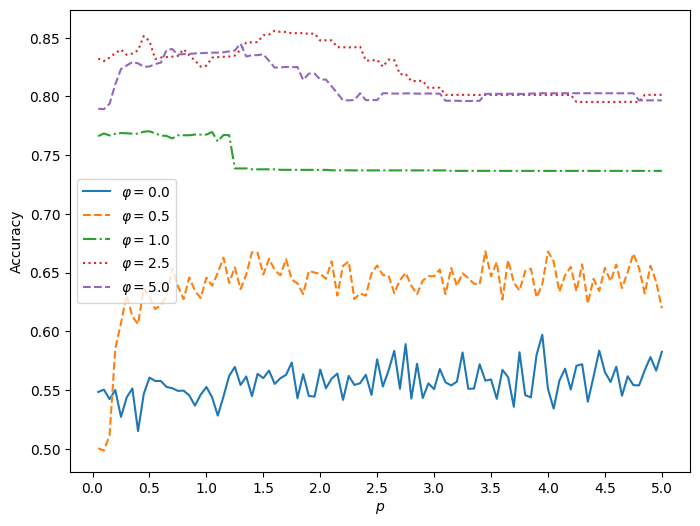

In [36]:
# Create a figure and axes
plt.figure(figsize=(8, 6))
ax3 = plt.gca() # Get the current axes

# Plot each curve individually
sns.lineplot(x = pvals, y = mean_accuracies[0,:], label = r'$\varphi = 0.0$', ax = ax3)
sns.lineplot(x = pvals, y = mean_accuracies[1,:], label = r'$\varphi = 0.5$', linestyle="--", ax = ax3)
sns.lineplot(x = pvals, y = mean_accuracies[2,:], label = r'$\varphi = 1.0$', linestyle="-.", ax = ax3)
sns.lineplot(x = pvals, y = mean_accuracies[3,:], label = r'$\varphi = 2.5$', linestyle=":", ax = ax3)
sns.lineplot(x = pvals, y = mean_accuracies[4,:], label = r'$\varphi = 5.0$', linestyle="--", ax = ax3)

# Add labels and title
ax3.set_xlabel(r'$p$')
ax3.set_ylabel('Accuracy')
# ax3.set_title('Multiple Curves on a Single Seaborn Line Plot')
ax3.legend() # Display the legend for the labels
# Set specific x-axis tick locations
ax3.set_xticks(np.arange(0, 5.5, 0.5))

# Set specific x-axis tick labels
# ax.set_xticklabels(np.arange(0, 5.5, 0.5)

plt.show()

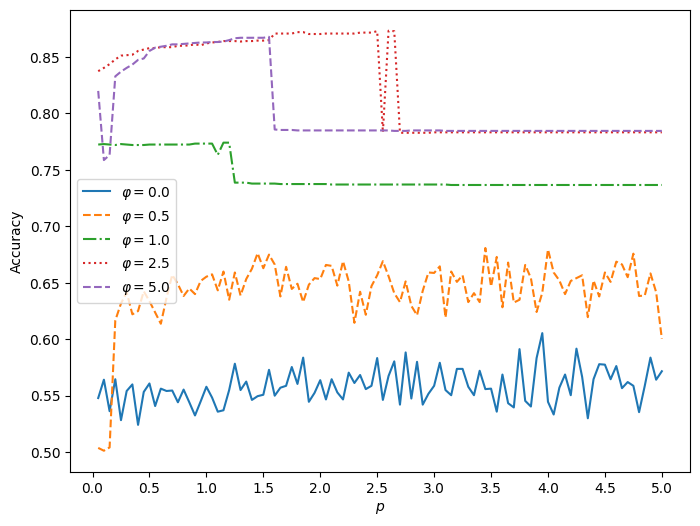

In [37]:
# Create the line plot of Accuracy

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax3 = plt.gca() # Get the current axes

# Plot each curve individually
sns.lineplot(x = pvals, y = median_accuracies[0,:], label = r'$\varphi = 0.0$', ax = ax3)
sns.lineplot(x = pvals, y = median_accuracies[1,:], label = r'$\varphi = 0.5$', linestyle="--", ax = ax3)
sns.lineplot(x = pvals, y = median_accuracies[2,:], label = r'$\varphi = 1.0$', linestyle="-.", ax = ax3)
sns.lineplot(x = pvals, y = median_accuracies[3,:], label = r'$\varphi = 2.5$', linestyle=":", ax = ax3)
sns.lineplot(x = pvals, y = median_accuracies[4,:], label = r'$\varphi = 5.0$', linestyle="--", ax = ax3)

# Add labels and title
ax3.set_xlabel(r'$p$')
ax3.set_ylabel('Accuracy')
# ax3.set_title('Multiple Curves on a Single Seaborn Line Plot')
ax3.legend() # Display the legend for the labels
# Set specific x-axis tick locations
ax3.set_xticks(np.arange(0, 5.5, 0.5))

plt.show()

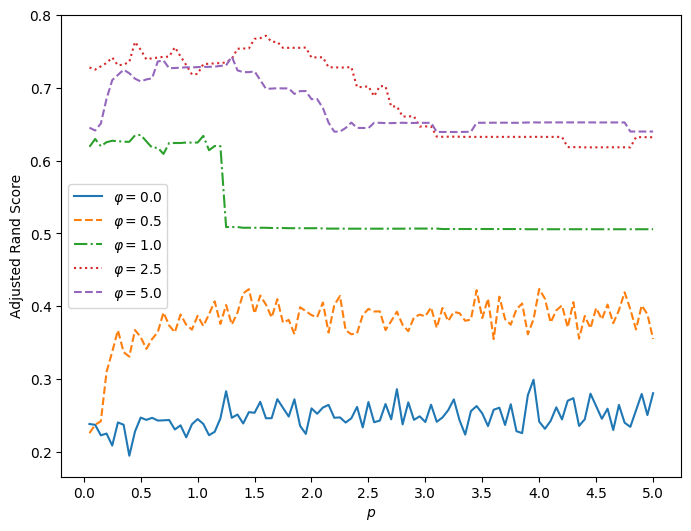

In [38]:
# Create the line plot of Accuracy

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax3 = plt.gca() # Get the current axes

# Plot each curve individually
sns.lineplot(x = pvals, y = mean_adj_rand_scores[0,:], label = r'$\varphi = 0.0$', ax = ax3)
sns.lineplot(x = pvals, y = mean_adj_rand_scores[1,:], label = r'$\varphi = 0.5$', linestyle="--", ax = ax3)
sns.lineplot(x = pvals, y = mean_adj_rand_scores[2,:], label = r'$\varphi = 1.0$', linestyle="-.", ax = ax3)
sns.lineplot(x = pvals, y = mean_adj_rand_scores[3,:], label = r'$\varphi = 2.5$', linestyle=":", ax = ax3)
sns.lineplot(x = pvals, y = mean_adj_rand_scores[4,:], label = r'$\varphi = 5.0$', linestyle="--", ax = ax3)

# Add labels and title
ax3.set_xlabel(r'$p$')
ax3.set_ylabel('Adjusted Rand Score')
# ax3.set_title('Multiple Curves on a Single Seaborn Line Plot')
ax3.legend() # Display the legend for the labels
# Set specific x-axis tick locations
ax3.set_xticks(np.arange(0, 5.5, 0.5))

plt.show()

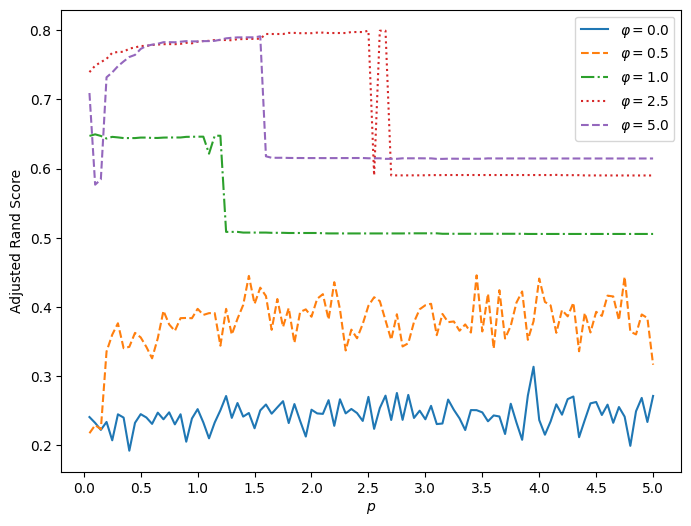

In [39]:
# Create the line plot of Accuracy

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax3 = plt.gca() # Get the current axes

# Plot each curve individually
sns.lineplot(x = pvals, y = median_adj_rand_scores[0,:], label = r'$\varphi = 0.0$', ax = ax3)
sns.lineplot(x = pvals, y = median_adj_rand_scores[1,:], label = r'$\varphi = 0.5$', linestyle="--", ax = ax3)
sns.lineplot(x = pvals, y = median_adj_rand_scores[2,:], label = r'$\varphi = 1.0$', linestyle="-.", ax = ax3)
sns.lineplot(x = pvals, y = median_adj_rand_scores[3,:], label = r'$\varphi = 2.5$', linestyle=":", ax = ax3)
sns.lineplot(x = pvals, y = median_adj_rand_scores[4,:], label = r'$\varphi = 5.0$', linestyle="--", ax = ax3)

# Add labels and title
ax3.set_xlabel(r'$p$')
ax3.set_ylabel('Adjusted Rand Score')
# ax3.set_title('Multiple Curves on a Single Seaborn Line Plot')
ax3.legend() # Display the legend for the labels
# Set specific x-axis tick locations
ax3.set_xticks(np.arange(0, 5.5, 0.5))

plt.show()

In [40]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
max_values = ( np.max(mean_accuracies, axis = 1) )
print('max_values:', max_values)
max_mean_accuracies_all = []
max_indices_pvals_all = []
mmm = 0
for max_value in max_values:
  indices_of_max = np.where(mean_accuracies[mmm,:] == max_value)
  max_mean_accuracies = mean_accuracies[mmm][indices_of_max]
  max_indices_pvals = pvals[indices_of_max]
  #
  max_mean_accuracies_all.append(max_mean_accuracies)
  max_indices_pvals_all.append(max_indices_pvals)
  # print('indices_of_max', indices_of_max[0])
  # print('max_mean_accuracies:', max_mean_accuracies)
  # print('max_indices_pvals:', max_indices_pvals)
  mmm += 1

# df_max_mean_accuracies = pd.DataFrame(max_mean_accuracies_all, index = jdm_vphis, columns = ['max_mean_accuracies'])
df_max_mean_accuracies = pd.DataFrame(max_mean_accuracies_all, index = jdm_vphis)
display(df_max_mean_accuracies)
print()

df_max_indices_pvals = pd.DataFrame(max_indices_pvals_all, index = jdm_vphis)
display(df_max_indices_pvals)
print()

max_values: [0.59713889 0.66822222 0.77038889 0.856      0.84508333]


,0
0.0,0.597139
0.5,0.668222
1.0,0.770389
2.5,0.856000
5.0,0.845083


,0
0.0,3.95
0.5,3.45
1.0,0.50
2.5,1.60
5.0,1.30
